In [1]:
# --- Imports ---
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random


from auction import Auction
from player import RangePlayer

# Ensure plots render inline
%matplotlib inline


In [2]:
# --- Simulation Configuration ---

EPSILON = 0.00001

slow_speed = (0.0, 0.4)
slow_mean = 0.9
fast_mean = 0.7  # fixed to isolate speed effect

starts = np.linspace(0, 0.7, 100)
fast_speed_ranges = [(round(start, 3), round(start + 0.3, 3)) for start in starts]

num_slow = 5
num_fast = 5
num_rounds = 216000
bid_range_width = 0.1


In [3]:
# --- Run Simulations ---

results = []

for fast_speed in fast_speed_ranges:
    players = []

    # Create slow (non-reactive) players
    for i in range(num_slow):
        speed = (
            random.uniform(*slow_speed),
            random.uniform(*slow_speed)
        )
        bid_range = (
            slow_mean,
            bid_range_width
        )
        players.append(RangePlayer(i, speed, bid_range, reactive=False))

    # Create fast (reactive) players
    for i in range(num_slow, num_slow + num_fast):
        speed = (
            random.uniform(*fast_speed),
            random.uniform(*fast_speed)
        )
        bid_range = (
            fast_mean,
            bid_range_width
        )
        players.append(RangePlayer(i, speed, bid_range, reactive=True))

    auction = Auction(players, cutoff_time_range=(0.6, 0.7 - EPSILON), sealed_bids=False)
    round_results, winnings = auction.run_simulation(num_rounds)

    fast_ids = [p.player_id for p in players if p.reactive]
    slow_ids = [p.player_id for p in players if not p.reactive]

    fast_profits = []
    slow_profits = []

    for r in round_results:
        cutoff_time = r["cutoff_time"]
        submit_bys = r["submit_bys"]
        winner = r["winner"]
        winning_id = winner[0] if winner else None

        for pid in fast_ids:
            if submit_bys[pid] < cutoff_time:
                if pid == winning_id:
                    fast_profits.append(winner[2])  # actual profit
                else:
                    fast_profits.append(0.0)  # submitted but lost
            # skip if bid was late (missed cutoff)

        for pid in slow_ids:
            if submit_bys[pid] < cutoff_time:
                if pid == winning_id:
                    slow_profits.append(winner[2])
                else:
                    slow_profits.append(0.0)


    fast_wins = sum(1 for r in round_results
                    if r['winner'] and r['winner'][0] in fast_ids and
                    r["submit_bys"][r['winner'][0]] < r["cutoff_time"])

    slow_wins = sum(1 for r in round_results
                    if r['winner'] and r['winner'][0] in slow_ids and
                    r["submit_bys"][r['winner'][0]] < r["cutoff_time"])


    total_fast_bids = total_fast_missed = total_slow_bids = total_slow_missed = 0
    for r in round_results:
        cutoff = r["cutoff_time"]
        submit_bys = r["submit_bys"]
        for pid in fast_ids:
            if submit_bys[pid] >= cutoff:
                total_fast_missed += 1
            total_fast_bids += 1
        for pid in slow_ids:
            if submit_bys[pid] >= cutoff:
                total_slow_missed += 1
            total_slow_bids += 1

    results.append({
        "fast_speed_range": fast_speed,
        "fast_max_speed": fast_speed[1],
        "slow_total_profit": round(sum(slow_profits), 5),
        "slow_win_rate": round(slow_wins / num_rounds, 5),
        "fast_total_profit": round(sum(fast_profits), 5),
        "fast_win_rate": round(fast_wins / num_rounds, 5),
        "fast_miss_rate": round(total_fast_missed / total_fast_bids, 5),
        "slow_miss_rate": round(total_slow_missed / total_slow_bids, 5)
    })

df = pd.DataFrame(results)
df["fast_speed_range"] = df["fast_speed_range"].astype(str)
df.to_csv("speed_grid__speeds_results.csv", index=False)
df.head()


,fast_speed_range,fast_max_speed,slow_total_profit,slow_win_rate,fast_total_profit,fast_win_rate,fast_miss_rate,slow_miss_rate
0,"(np.float64(0.0), np.float64(0.3))",0.300,7451.92361,0.50367,7788.39869,0.49633,0.0,0.0
1,"(np.float64(0.007), np.float64(0.307))",0.307,7521.18025,0.50798,7583.31688,0.49202,0.0,0.0
2,"(np.float64(0.014), np.float64(0.314))",0.314,6613.51948,0.44869,10584.10885,0.55131,0.0,0.0
3,"(np.float64(0.021), np.float64(0.321))",0.321,6954.97246,0.47011,9603.38013,0.52989,0.0,0.0
4,"(np.float64(0.028), np.float64(0.328))",0.328,7072.98867,0.47898,8888.49295,0.52102,0.0,0.0


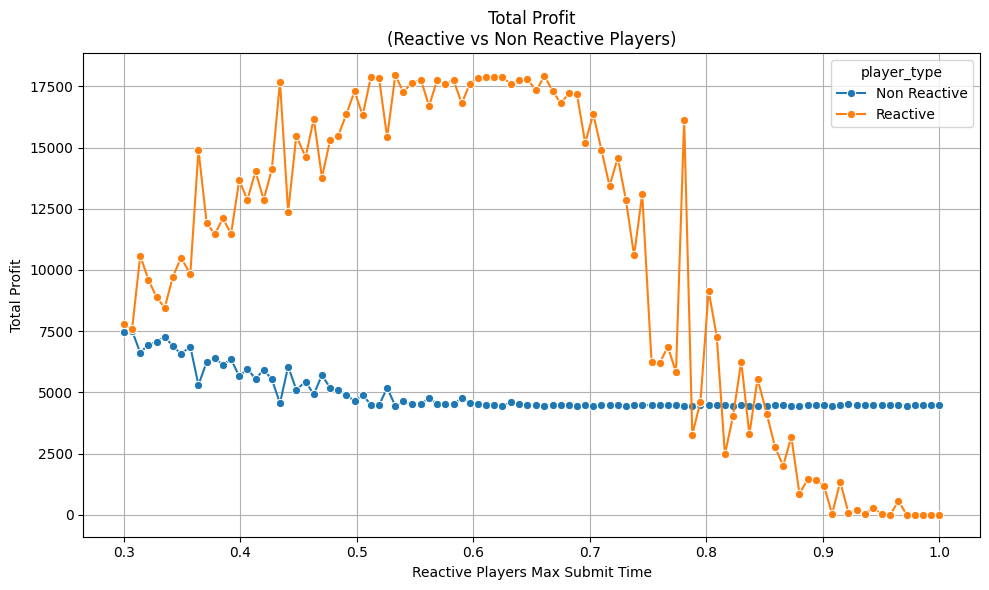

In [4]:
profit_df = pd.concat([
    df[["fast_max_speed", "slow_total_profit"]].rename(columns={"slow_total_profit": "total_profit"}).assign(player_type="Non Reactive"),
    df[["fast_max_speed", "fast_total_profit"]].rename(columns={"fast_total_profit": "total_profit"}).assign(player_type="Reactive")
])

plt.figure(figsize=(10, 6))
sns.lineplot(data=profit_df, x="fast_max_speed", y="total_profit", hue="player_type", marker="o")
plt.title("Total Profit\n(Reactive vs Non Reactive Players)")
plt.xlabel("Reactive Players Max Submit Time")
plt.ylabel("Total Profit")
plt.grid(True)
plt.tight_layout()
plt.savefig("profit_comparison_by_speed.png")
plt.show()


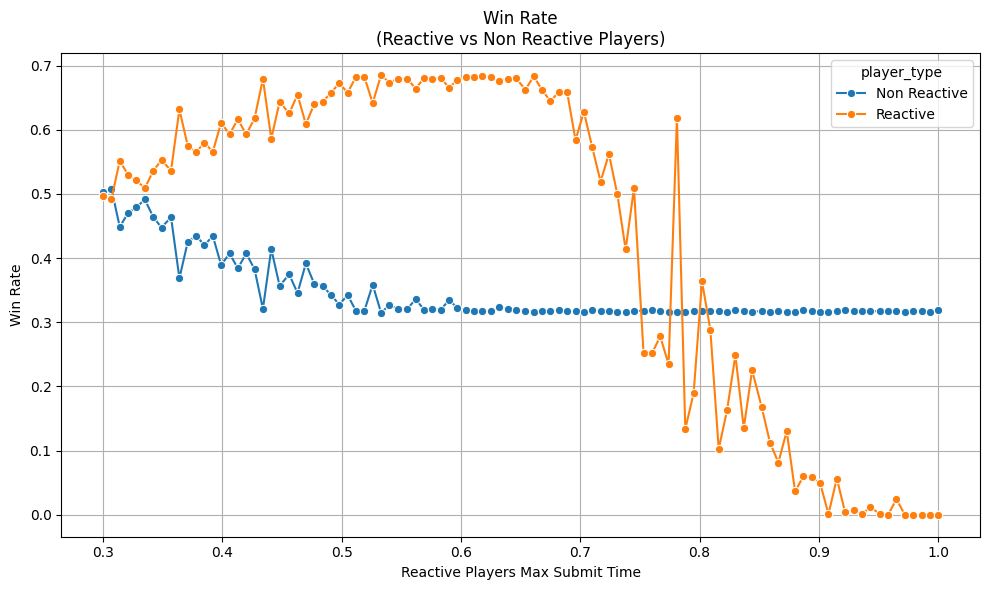

In [5]:
winrate_df = pd.concat([
    df[["fast_max_speed", "slow_win_rate"]].rename(columns={"slow_win_rate": "win_rate"}).assign(player_type="Non Reactive"),
    df[["fast_max_speed", "fast_win_rate"]].rename(columns={"fast_win_rate": "win_rate"}).assign(player_type="Reactive")
])

plt.figure(figsize=(10, 6))
sns.lineplot(data=winrate_df, x="fast_max_speed", y="win_rate", hue="player_type", marker="o")
plt.title("Win Rate\n(Reactive vs Non Reactive Players)")
plt.xlabel("Reactive Players Max Submit Time")
plt.ylabel("Win Rate")
plt.grid(True)
plt.tight_layout()
plt.savefig("winrate_comparison_by_speed.png")
plt.show()
